In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.17
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [55]:
import pandas as pd

In [56]:
# tensorflow device 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-05-08 16:42:27.934229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 16:42:27.934331: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 16:42:27.934363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 16:42:28.283106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 16:42:28.283135: I tensorflow/core/co

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12654577214373750847
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5621415936
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10308167385982630896
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [57]:
import numpy as np
import random
import os
import gc

In [58]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [59]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [6]:
# 책 언어식별을 위해 lingua 설치
# https://github.com/pemistahl/lingua-py
!pip install lingua-language-detector

In [60]:
# https://gist.github.com/nealrs/96342d8231b75cf4bb82
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [61]:
from stop_words import get_stop_words
# 불용어 리스트
languages = [
   'Arabic',
   'Bulgarian',
   'Catalan',
   'Czech',
   'Danish',
   'Dutch',
   'English',
   'Finnish',
   'French',
   'German',
   'Hungarian',
   'Indonesian',
   'Italian',
   'Norwegian',
   'Polish',
   'Portuguese',
   'Romanian',
   'Russian',
   'Spanish',
   'Swedish',
   'Turkish',
   'Ukrainian'
]
my_stop_word_list = []
for i in languages:
    my_stop_word_list.append(get_stop_words(i.lower()))
my_stop_word_list = sum(my_stop_word_list, [])
my_stop_word_list = my_stop_word_list + ['paperbook', 'hardcover']


In [62]:
from bs4 import BeautifulSoup
import re

#main 단어만 추출 > 차후 이 단어들로 BERTopic 테마 만들 것
def preprocessing_sentence(sentence, remove_stopwords = True):
    #소문자화
    sentence = sentence.lower()
    #html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    #괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #쌍따옴표 제거
    sentence = re.sub('"', ' ', sentence) 
    #약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #소유격 제거
    sentence = re.sub(r"'s\b"," ",sentence)
    #특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)
    
    #불용어 제거
    if my_stop_word_list:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens


In [63]:
def preprocessing_data(df):
    # Decompose Location by split
    df['City'] = [(i.split(',')[0]).lstrip().title() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().title() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().title() for i in df['Location']]
    
    # preprocessing
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    #df['City'] = np.where((df['City'] == '')|(df['City'].astype(str) == 'nan')|(df['City'].astype(str) == 'N/A'), 'UnKnown', df['City'])
    #df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan')|(df['State'].astype(str) == 'N/A'), 'UnKnown', df['State'])
    #df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan')|(df['Country'].astype(str) == 'N/A')
    #                                              |(df['Country'].astype(str) == 'N/A - On The Road')|(df['Country'].astype(str) == 'X')
    #                                              |(df['Country'].astype(str) == 'Far Away...')|(df['Country'].astype(str) == 'C')
    #                                              |(df['Country'].astype(str) == 'We`Re Global!')|(df['Country'].astype(str) == 'Travelling....')
    #                                              #영원한 중국!
    #                                              |(df['Country'].astype(str) == 'La Chine Éternelle !')
    #                         ,'UnKnown', df['Country'])
	#
    ## train에 있는 정보로 County 바꾸기
    #df.loc[df['State'] == 'Michigan Usa', 'Country'] = 'Usa'
    #df.loc[df['State'] == 'Wicklow', 'Country'] = 'Ireland'
    #df.loc[df['State'] == 'Ilfov', 'Country'] = ''
    #df.loc[df['State'] == 'Liege', 'Country'] = 'Belgium'
    #df.loc[df['State'] == 'Estremadura', 'Country'] = 'Portugal'
    #df.loc[df['State'] == 'Aberdeenshire', 'Country'] = 'United Kingdom'
    #df.loc[df['State'] == 'Wi', 'Country'] = 'Wisconsin'
    #
    ## 미국 Country name 통일
    #df.loc[df['Country'] == 'America', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United State', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United States', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S.A.', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'New York', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S. Of A.', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'United Staes', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'U.S>', 'Country'] = 'Usa'
    #df.loc[df['Country'] == 'Usa Now', 'Country'] = 'Usa'
    #
    ## 영국 Country name 통일
    #df.loc[df['Country'] == 'England', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Scotland', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Wales', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Ireland', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'U.K.', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Usa (Currently Living In England)', 'Country'] = 'United Kingdom'
    #df.loc[df['Country'] == 'Uk', 'Country'] = 'United Kingdom'
    #
    ## 스페인 Country name 통일
    #df.loc[df['Country'] == 'España ', 'Country'] = 'Spain'
    
    return df
    

In [ ]:
!pip install catboost

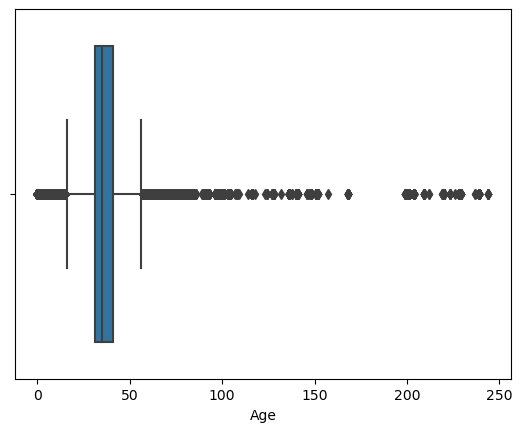

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='Age', data=train)
plt.show()

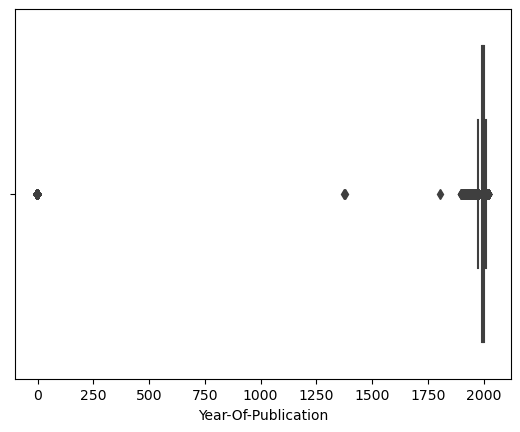

In [65]:
sns.boxplot(x='Year-Of-Publication', data=train)
plt.show()

In [66]:
from lingua import Language, LanguageDetectorBuilder
from tqdm import tqdm

def feature_engineering(df):
    
    # Book-Title로 도서 언어분류
    df['prep_title'] = df['Book-Title'].apply(preprocessing_sentence)
    detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().with_low_accuracy_mode().build()
    
    all = []
    for row in tqdm(df['prep_title'].unique()):
        try:
            language = detector.detect_language_of(row)
        except:
            language = "error"
            print("This row throws and error:", row)
        all.append(language)
    prep_title = pd.DataFrame(df['prep_title'].unique(), columns = ['prep_title'])
    all = [i.name if str(i) != 'None' else 'None' for i in all]
    Language = pd.DataFrame(all, columns = ['Language'])
    prep_title = pd.concat([prep_title, Language], axis = 1)
    df = pd.merge(df, prep_title, on = 'prep_title', how = 'inner')
    
    df = df.drop(columns = ['prep_title'])
    
    # Age 그룹화    
    labels = ['0-3','3-6','6-8','8-12','12-18','18-54','55-64','65+']
    bins = [0, 3, 6, 8, 12, 18, 54, 64, 250]
    #labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    #bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)
    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 출판년도 그룹화
    labels = ['Unknown', '-1900', '1900-1970', '1970-2000', '2000-2010', '2010-2020', '2020-']
    bins = [-1, 0, 1900, 1970, 2000, 2010, 2020, 3000]
    #labels = ['Unknown', '-1900', '1900-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    #bins = [-1, 0, 1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)
    
    # count변수 추가
    df = df.join(
                df.groupby('User-ID')['User-ID'].aggregate(['count']), #'mean', pd.Series.mode
                on='User-ID'
                )
    df = df.rename(columns = {'count': 'User_count'})   
    
    df = df.join(
                df.groupby('Book-Title')['Book-Title'].aggregate(['count']), #'mean', pd.Series.mode
                on='Book-Title'
                )
    df = df.rename(columns = {'count': 'Rating_count'})

    df = df.join(
                df.groupby('Book-Author')['Book-Author'].aggregate(['count']), #'mean', pd.Series.mode
                on='Book-Author'
                )
    df = df.rename(columns = {'count': 'Author_count'})        

    return df

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

FEATURE = ['User-ID','Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb', 'Language'] #'', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

/tmp/ipykernel_18032/3976399020.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text
 28%|████████████████████▉                                                     | 52051/183844 [00:50<02:07, 1032.08it/s]

In [ ]:
X_train = train_lb.drop(columns = ['ID', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])

In [16]:
list(set(X_train.columns) - set(FEATURE))

['Rating_count', 'Year-Of-Publication', 'Age']

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()    # create an object of class

scaler_FEATURE = list(set(X_train.columns) - set(FEATURE))
scaler.fit(X_train[scaler_FEATURE])       #  fit on training i/p data

X_train[scaler_FEATURE] = scaler.transform(X_train[scaler_FEATURE])    # transform model on both traing and testing data
x_test[scaler_FEATURE] = scaler.transform(x_test[scaler_FEATURE])

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (5, 5))
clustermap = sns.clustermap(X_train.corr(), vmin = -1, vmax = 1, annot = True)

In [ ]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500,
                          devices = '0'
                          )

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold

k = 20 # a number of folds 
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb', 'Pub_gb', 'Language']#, 'Topic_num']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    # OVER SAMPLING - SMOTE
    #smote_sample = SMOTE(random_state=113, sampling_strategy='minority') 
    #X_train_fold, y_train_fold = smote_sample.fit_resample(X_train_fold, y_train_fold)
    #X_valid_fold, y_valid_fold = smote_sample.fit_resample(X_valid_fold, y_valid_fold)
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


In [ ]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(train_lb.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()


In [ ]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

In [ ]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [ ]:
sub.to_csv('submit_cat+20-folds_Languege.csv', index=False,encoding="utf-8-sig")